In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import pylab as pl
import plotly.express as px

In [2]:
# creo un dizionario in cui andrò a mettere tutti i modelli dentro
models_atmos = {}

In [3]:
#Costruisco il dizionario models_atmos con il nome del modello, il nomde del percorso di tutti i file *.nc di ogni modello e il nome di .nc, cioè il modello remapbil

#Percorso dei file
name_models_atmos = '/work/users/guest/sbeltrami/prova/name_atmos_model.txt'
path_models_atmos = '/work/users/guest/sbeltrami/prova/path_atmos_model.txt'
path_remap_models_atmos = '/work/users/guest/sbeltrami/prova/path_remap_atmos_model.txt'
# Apro i 3 file in modalità di lettura
with open(name_models_atmos, 'r') as file:
    # Leggo tutte le righe del file e salvo in una lista
    lines_name_models_atmos = file.readlines()
with open(path_models_atmos, 'r') as file:
    lines_path_models_atmos = file.readlines()
with open(path_remap_models_atmos, 'r') as file:
    lines_path_remap_models_atmos = file.readlines()

In [4]:
# Itero su tutte le righe dei 3 file e organizzo i dati nel dizionario
for line_name, line_path, line_path_remap in zip(lines_name_models_atmos, lines_path_models_atmos, lines_path_remap_models_atmos): #zip per iterare sulle 3 liste contemporaneamente
    model_name = line_name.strip() #senza spazi bianchi
    #model_name è la chiave principale
    # Inizializzo il dizionario se non esiste ancora
    if model_name not in models_atmos:
        models_atmos[model_name] = {}
    # Aggiungo name, path, path remap come sottochiavi
    models_atmos[model_name]['atmos name'] = model_name
    models_atmos[model_name]['atmos path'] = line_path.strip()
    models_atmos[model_name]['atmos path remap'] = line_path_remap.strip()
for name in models_atmos.keys():
    path_remap = models_atmos[name]['atmos path remap']
    if os.path.exists(path_remap): #Se il file esiste
        # Apro il dataset
        models_atmos[name]['atmos dataset'] = xr.open_dataset(path_remap)
        dataset = models_atmos[name]['atmos dataset']
        #peso il dataset
        models_atmos[name]['atmos dataset weighted'] = compute_dataset_weighted(dataset["ua"])
        #medie annuali con dataset pesato
        models_atmos[name]['atmos dataset annual mean'] = compute_annual_mean_weighted(models_atmos[name]['atmos dataset weighted'])
        print(models_atmos[name]['atmos name']) 

        #Seleziono il box del Nord Atlantico
        models_atmos[name]['atmos North Atlantic box'] = dataset.sel(lon=slice(280,360), lat=slice(20,80))
        na_box = models_atmos[name]['atmos North Atlantic box']
        #peso il dataset Nord Atlantico
        models_atmos[name]['atmos North Atlantic dataset weighted'] = compute_dataset_weighted(na_box["ua"])
        #calcolo la media annuale del dataset Nord Atlantico
        models_atmos[name]['atmos North Atlantic annual mean weighted'] = compute_annual_mean_weighted(models_atmos[name]['atmos North Atlantic dataset weighted'])
        #Seleziono la climatologia
        na_box_climat = na_box.sel(time=slice("1984-01", "2014-12"))
        #peso il dataset del periodo scelto per la climatologia
        models_atmos[name]['atmos North Atlantic climatology weighted'] = compute_dataset_weighted(na_box_climat["ua"])
        #calcolo la media annuale del dataset na sul periodo scelto
        models_atmos[name]['atmos North Atlantic annual mean climatology'] = compute_annual_mean_weighted(models_atmos[name]['atmos North Atlantic climatology weighted'])
        #Calcolo l'anomalia di ua rispetto alla climatologia scelta
        models_atmos[name]['atmos North Atlantic anomaly'] = compute_anomaly(models_atmos[name]['atmos North Atlantic annual mean weighted'],models_atmos[name]['atmos North Atlantic annual mean climatology'])
    else:
        print(f"Errore: Il file {path_remap} non esiste per il modello {name}")

TaiESM1
AWI-CM-1-1-MR
AWI-ESM-1-1-LR
BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CAS-ESM2-0
FGOALS-g3
CanESM5
CMCC-CM2-SR5
ACCESS-ESM1-5
ACCESS-CM2
E3SM-1-0
EC-Earth3
EC-Earth3-Veg
FIO-ESM-2-0
MPI-ESM-1-2-HAM
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
GISS-E2-1-G
GISS-E2-1-G-CC
GISS-E2-1-H
CESM2
CESM2-FV2
CESM2-WACCM
CESM2-WACCM-FV2
NorCPM1
NorESM2-LM
NorESM2-MM
GFDL-ESM4
NESM3
SAM0-UNICON
MCM-UA-1-0


In [5]:
#Creo una lista con il nome dei modelli
models_list_atmos = list(models_atmos.keys())

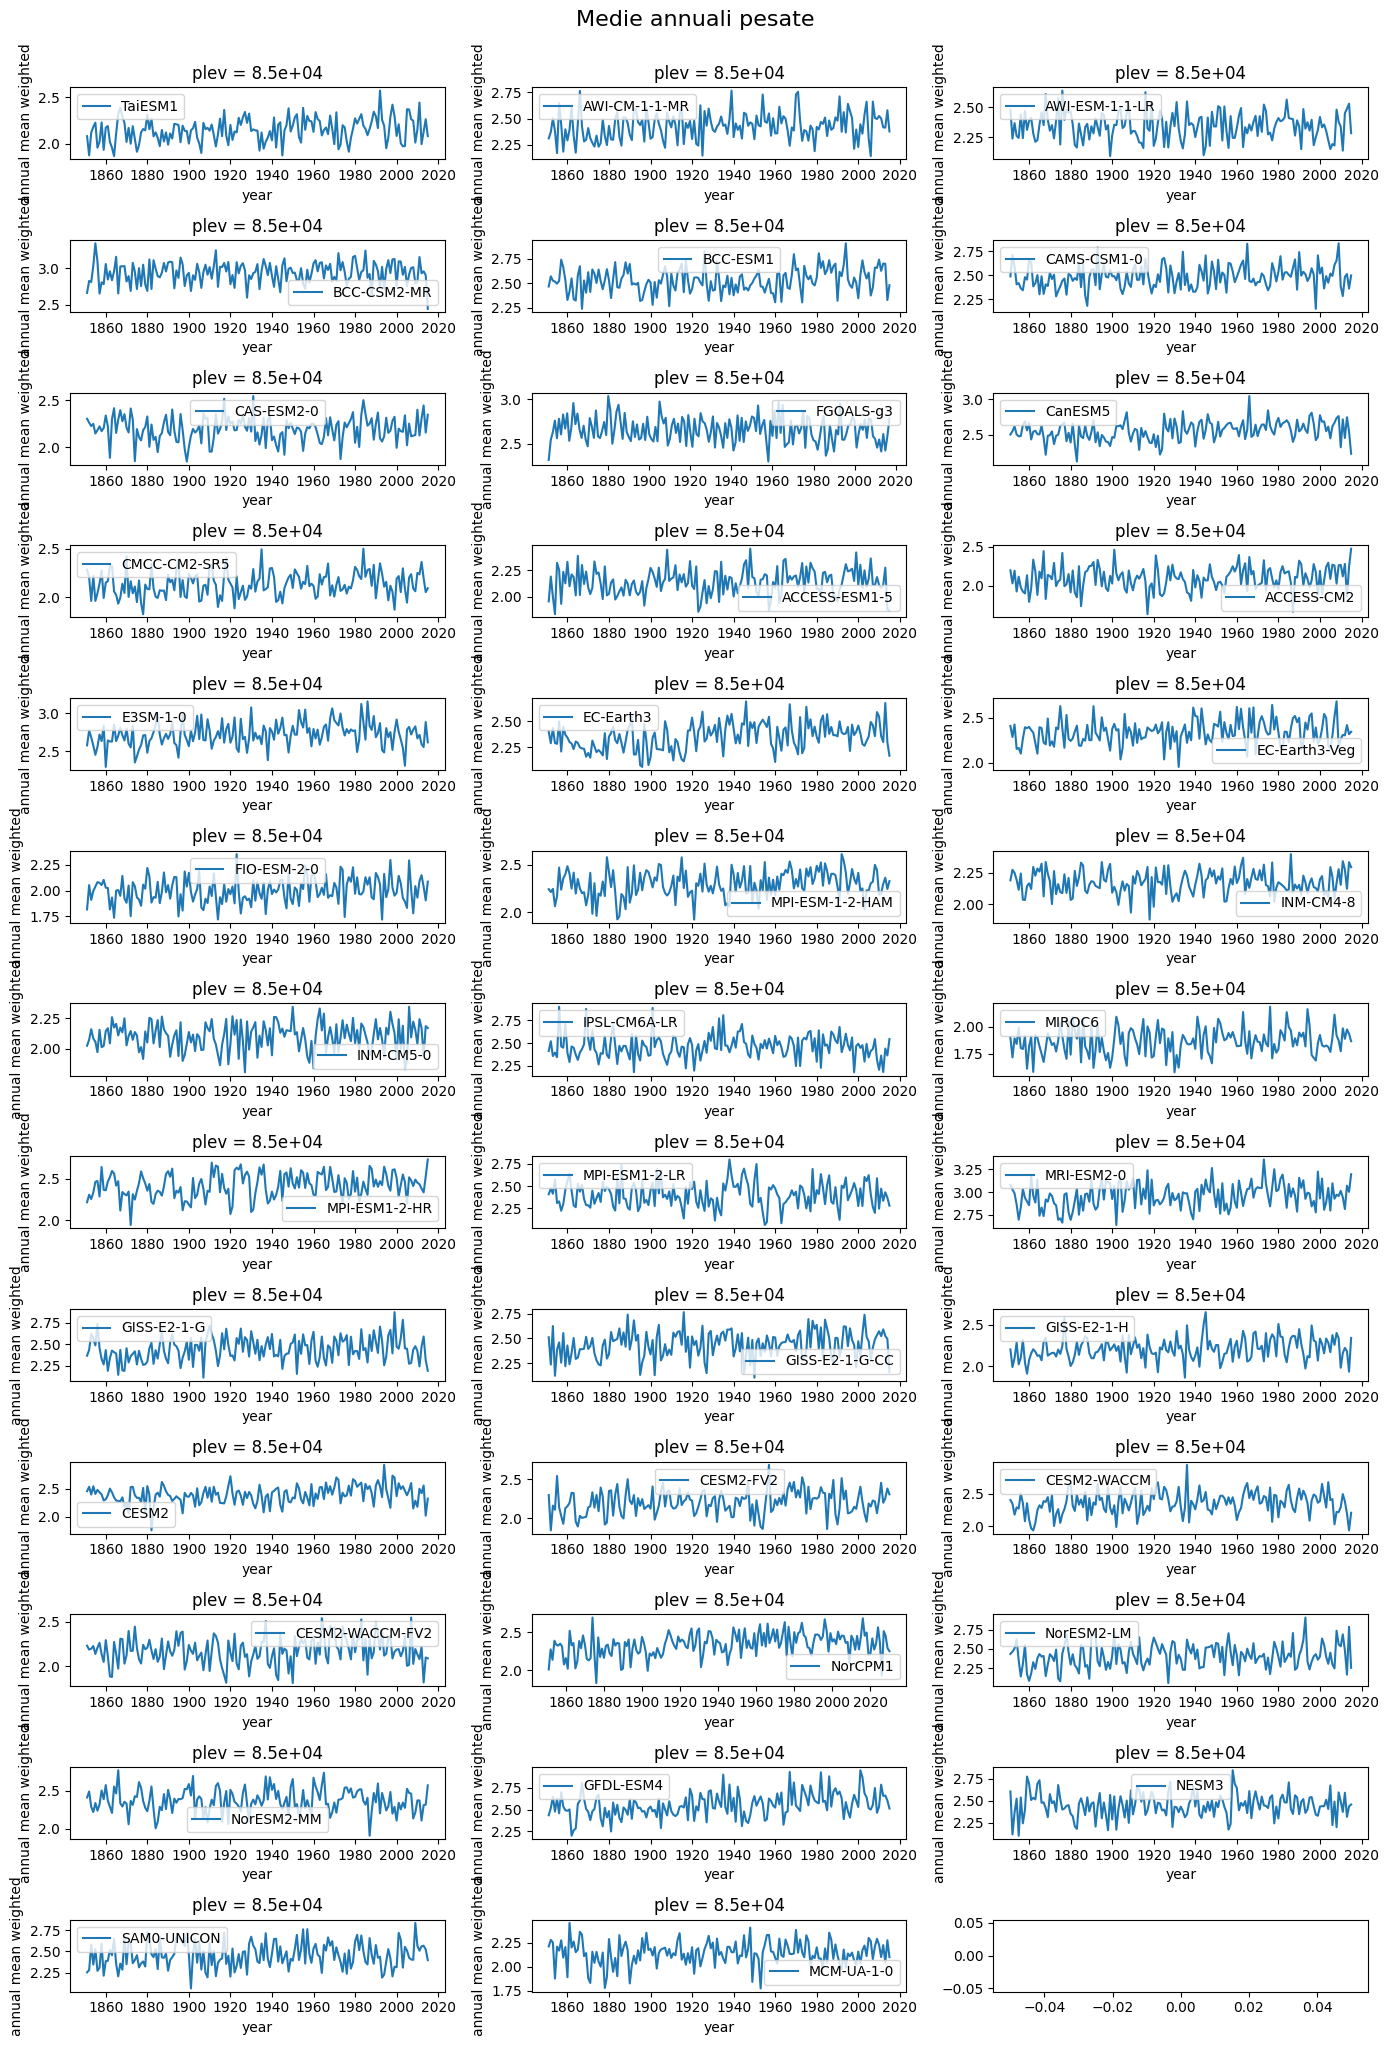

In [6]:
#plot medie annuali dei modelli
fig, ax = plt.subplots(nrows=(int(len(models_atmos)/3)+1),ncols=3,figsize=(14,20))
# Plot dei modelli
for i in range(int(len(models_atmos)/3)+1): #ciclo sulle righe
    for j in range(3): #ciclo sulle colonne
        models_index_list = i * 3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list_atmos):
            break
        model_name = models_list_atmos[models_index_list]
        data_array = models_atmos[model_name]['atmos North Atlantic annual mean weighted'].copy()
        data_array = data_array.assign_coords(time=data_array['time'].values.astype('datetime64[ns]')) #assegno un nuova coordinata tempo, .values restituisce i valori di time di data_array, converte i valori in datetime64[ns]
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()
        ax[i,j].set_ylabel('annual mean weighted')
        ax[i,j].set_xlabel('year')
        
for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()
# Titolo
fig.suptitle('Medie annuali pesate', fontsize=16, y=1.02)

plt.savefig('atmos_annual_mean_weighted.pdf', format='pdf')

In [7]:
#Nord Atlantico
#Creo una lista con il nome dei modelli
models_list_atmos = list(models_atmos.keys())

Nord Atlantico anomalie - Dataset ERA5

Text(0.5, 0.98, 'Anomalia Nord Atlantico ERA rispetto alla media climatologica 1984 - 2014')

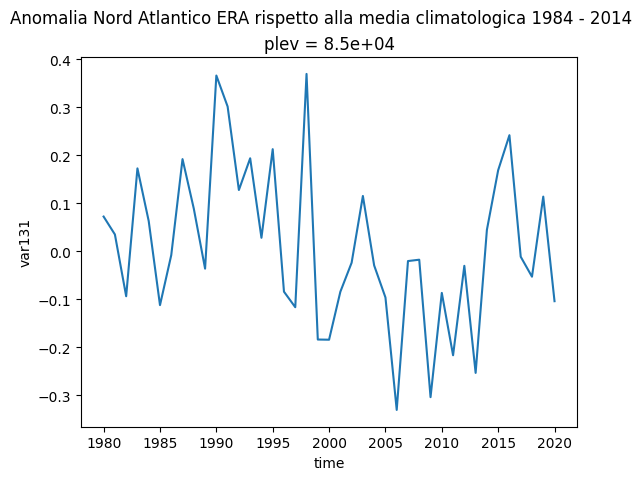

In [8]:
#ERA5 box Nord Atlantico
dataset_ERA_na=xr.open_dataset('/work/users/guest/sbeltrami/prova/ERA5_remap.nc').sel(lon=slice(280,360), lat=slice(20,80)) #seleziono lon lat del Nord Atlantico
#dataset pesato
dataset_ERA_weighted_na = compute_dataset_weighted(dataset_ERA_na["var131"])
#media annuale Nord Atlantico
annual_mean_era_na = compute_annual_mean_weighted(dataset_ERA_weighted_na)
#Scelgo periodo su cui calcolare la climatologia
era_na_1984_2014 = dataset_ERA_na.sel(time=slice("1984-01", "2014-12"))
#peso il dataset del periodo scelto
era_na_1984_2014_weighted = compute_dataset_weighted(era_na_1984_2014["var131"])
#calcolo la media annuale sul periodo scelto
annual_mean_era_na_30 = compute_annual_mean_weighted(era_na_1984_2014_weighted)
#Calcolo l'anomalia di tos rispetto al periodo di riferimento scelto
anomaly_era = compute_anomaly(annual_mean_era_na,annual_mean_era_na_30)
#plot
anomaly_era.plot()
plt.suptitle('Anomalia Nord Atlantico ERA rispetto alla media climatologica 1984 - 2014')

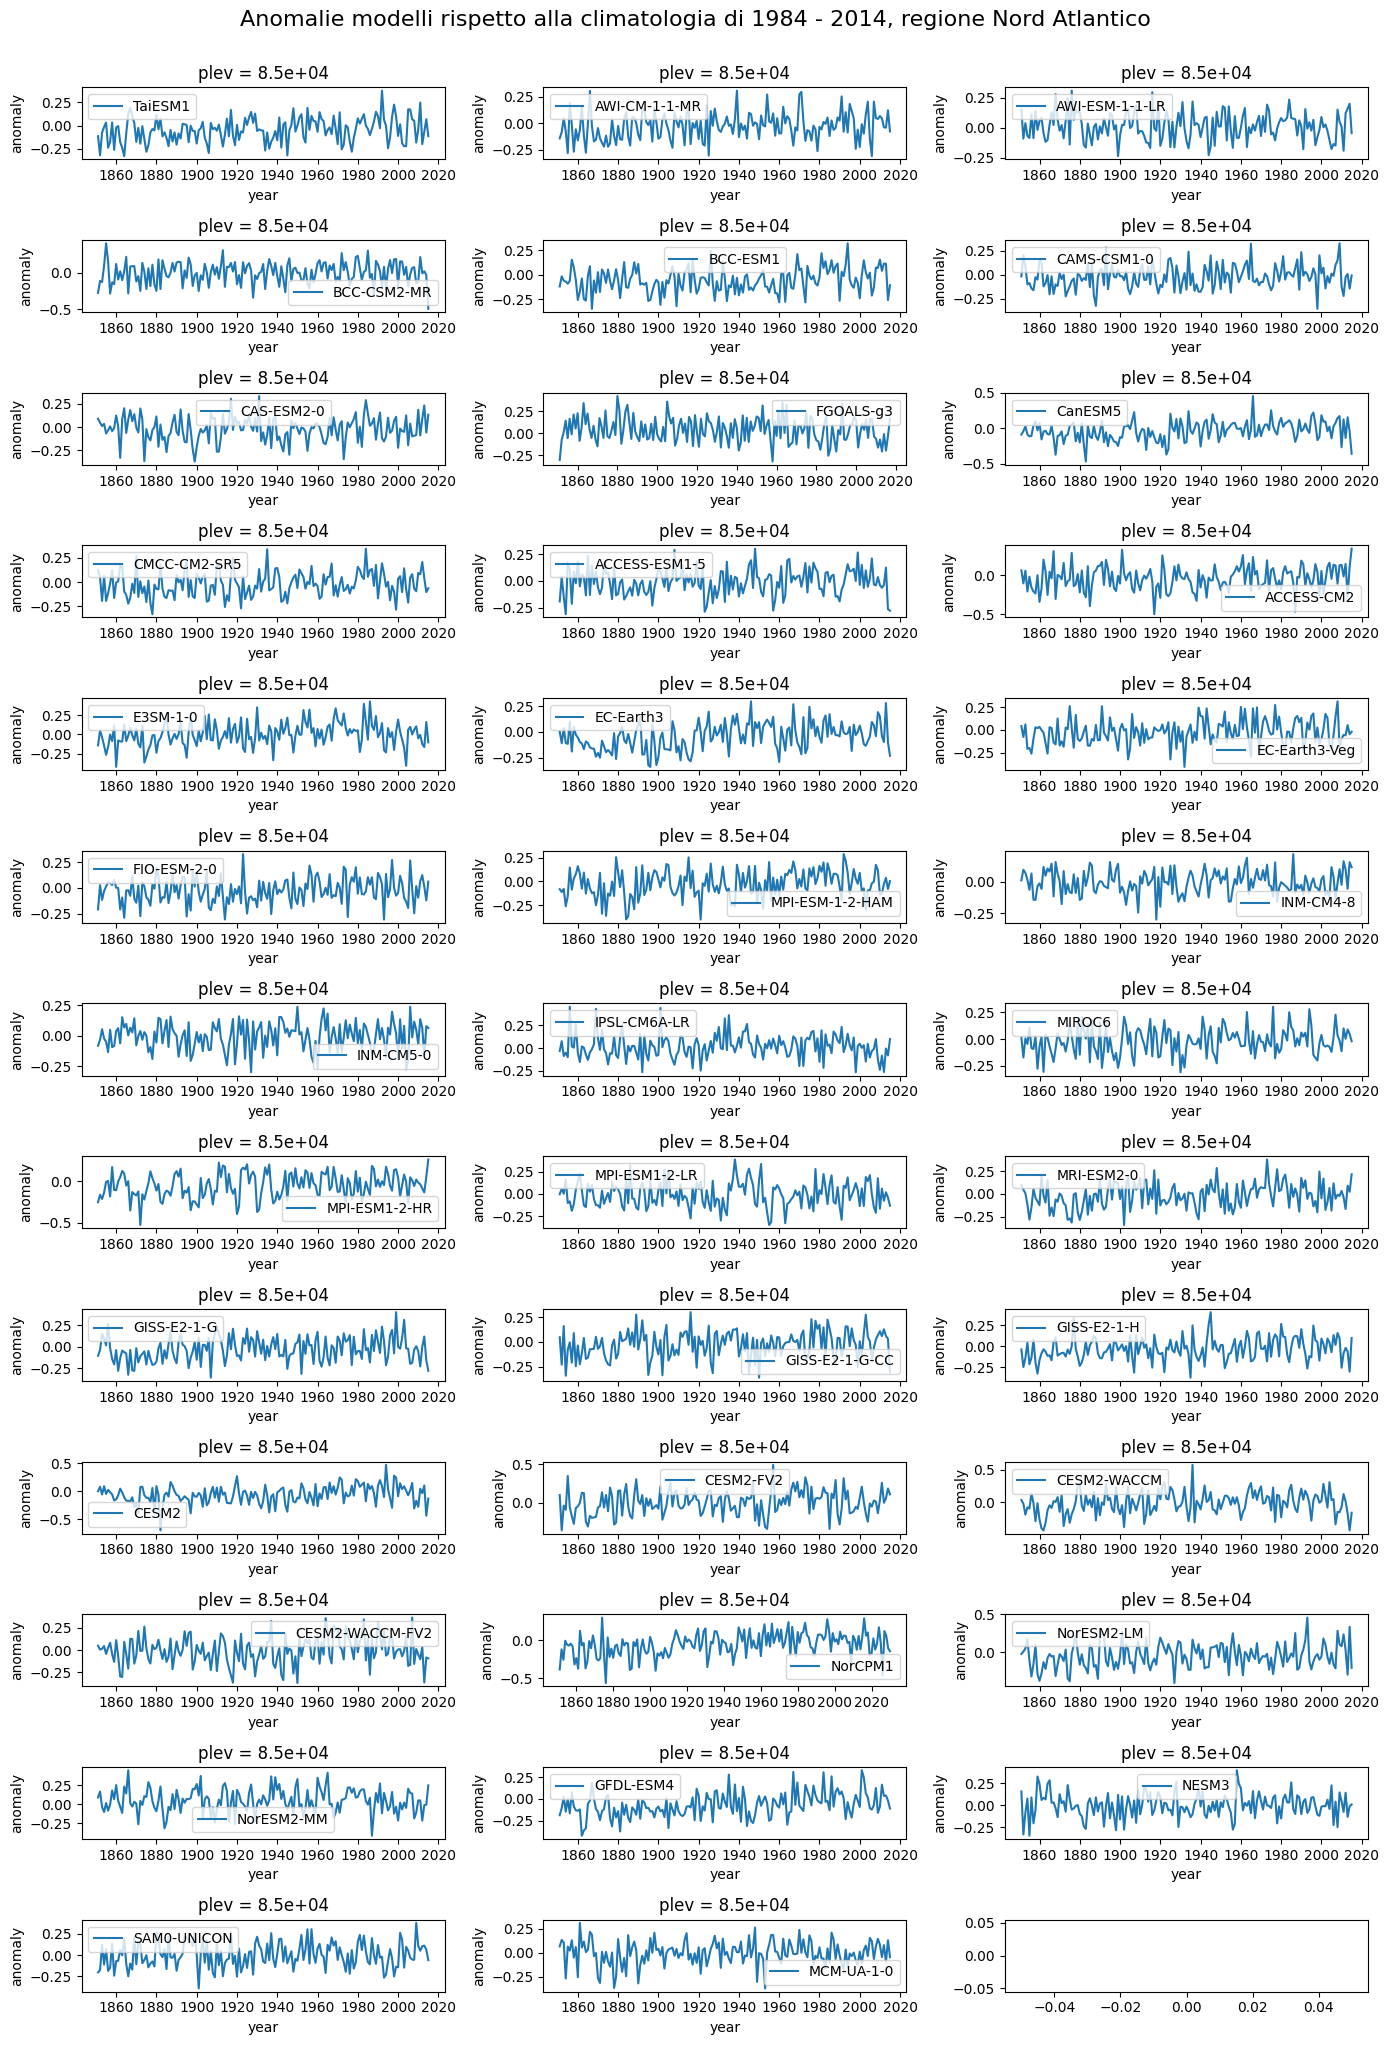

In [9]:
#Plot delle anomalie dei modelli
fig, ax = plt.subplots(nrows=(int(len(models_atmos)/3)+1),ncols=3,figsize=(14,20))

for i in range((int(len(models_atmos)/3)+1)): #ciclo sulle righe
    for j in range(3): #ciclo sulle colonne
        models_index_list = i * 3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list_atmos):
            break
        model_name = models_list_atmos[models_index_list]
        data_array = models_atmos[model_name]['atmos North Atlantic anomaly'].copy()
        data_array = data_array.assign_coords(time=data_array['time'].values.astype('datetime64[ns]')) #assegno un nuova coordinata tempo, .values restituisce i valori di time di data_array, converte i valori in datetime64[ns]
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()
        ax[i,j].set_ylabel('anomaly')
        ax[i,j].set_xlabel('year')
        
for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()
# Titolo
fig.suptitle('Anomalie modelli rispetto alla climatologia di 1984 - 2014, regione Nord Atlantico', fontsize=16, y=1.02)

plt.savefig('atmos_anomalies.pdf', format='pdf')

Bias : Medie stagionali (modello - osservazioni), con media climatologica delle osservazioni su periodo 1982 - 2014

Dataset ERA5

In [10]:
#Dataset ERA5
#Creo un dizionario in cui vado a mettere la media temporale per ogni stagione MAM, JJA, SON, DJF
era_na_seas_mean = {}
#Calcolo la media temporale su tutti e 4 i trimestri MAM = 1, JJA = 2, SON = 3, DJF = 4
for i in range(4):
    era_na_seas_mean[i+1] = compute_mean_resample_mar(dataset_ERA_na["var131"],"1982","2014",i)
era_na_seas_mean.keys()

dict_keys([1, 2, 3, 4])

Modelli

In [11]:
#Bias modelli
for name in models_atmos.keys():
    #Seleziono il box Nord Atlantico
    na_box = models_atmos[name]['atmos North Atlantic box']
    #media temporale delle stagioni MAM, JJA, SON
    for i in range(4): # ciclo su tutte le stagioni
        #Calcolo la media temporale per ogni stagione dei modelli, per un anno --> da aggiungere anni!
        model_na_seas_mean = compute_mean_resample_mar(na_box["ua"],"1982","2014",i)
        #Calcolo il bias modelli - dataset
        if (i+1) == 1: # MAM
            models_atmos[name]['atmos North Atlantic bias MAM'] = model_na_seas_mean - era_na_seas_mean[i+1]
        elif (i+1) == 2 : # JJA
            models_atmos[name]['atmos North Atlantic bias JJA'] = model_na_seas_mean - era_na_seas_mean[i+1]
        elif (i+1) == 3 : #SON
            models_atmos[name]['atmos North Atlantic bias SON'] = model_na_seas_mean - era_na_seas_mean[i+1]
        elif (i+1) == 4 : #DJF
            models_atmos[name]['atmos North Atlantic bias DJF'] = model_na_seas_mean - era_na_seas_mean[i+1]

In [12]:
model_na_seas_mean.shape

(1, 30, 40)

In [13]:
era_na_seas_mean[4].shape

(1, 30, 40)

In [14]:
#Conto quanti modelli hanno (0,20,40)
num_models = 0 #Inizializzo il conteggio
for name in models_atmos.keys():
    if models_atmos[name]['atmos North Atlantic bias DJF'].shape == (0,30,40):
        num_models = num_models + 1
        print("Il modello che ha shape (0,30,40) è: ", name)
print(num_models)

Il modello che ha shape (0,30,40) è:  ACCESS-ESM1-5
Il modello che ha shape (0,30,40) è:  ACCESS-CM2
2


In [15]:
print(models_list_atmos)

['TaiESM1', 'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'FGOALS-g3', 'CanESM5', 'CMCC-CM2-SR5', 'ACCESS-ESM1-5', 'ACCESS-CM2', 'E3SM-1-0', 'EC-Earth3', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'MPI-ESM-1-2-HAM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorCPM1', 'NorESM2-LM', 'NorESM2-MM', 'GFDL-ESM4', 'NESM3', 'SAM0-UNICON', 'MCM-UA-1-0']


In [16]:
models_atmos[models_list_atmos[10]]['atmos North Atlantic bias DJF'].shape

(0, 30, 40)

In [17]:
#Creo una lista con il nome dei modelli senza i modelli che hanno shape = (0,30,40)
models_list_atmos_new = [] #lista vuota
for i in range(len(models_list_atmos)): #ciclo su tutti i modelli della lista models_list_atmos
    if models_atmos[models_list_atmos[i]]['atmos North Atlantic bias DJF'].shape != (0,30,40): #Se il modello i-esimo ha shape (0,30,40) non lo inserisco in models_list_atmos_new
        models_list_atmos_new.append(models_list_atmos[i])
print(models_list_atmos_new)

['TaiESM1', 'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'FGOALS-g3', 'CanESM5', 'CMCC-CM2-SR5', 'E3SM-1-0', 'EC-Earth3', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'MPI-ESM-1-2-HAM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorCPM1', 'NorESM2-LM', 'NorESM2-MM', 'GFDL-ESM4', 'NESM3', 'SAM0-UNICON', 'MCM-UA-1-0']


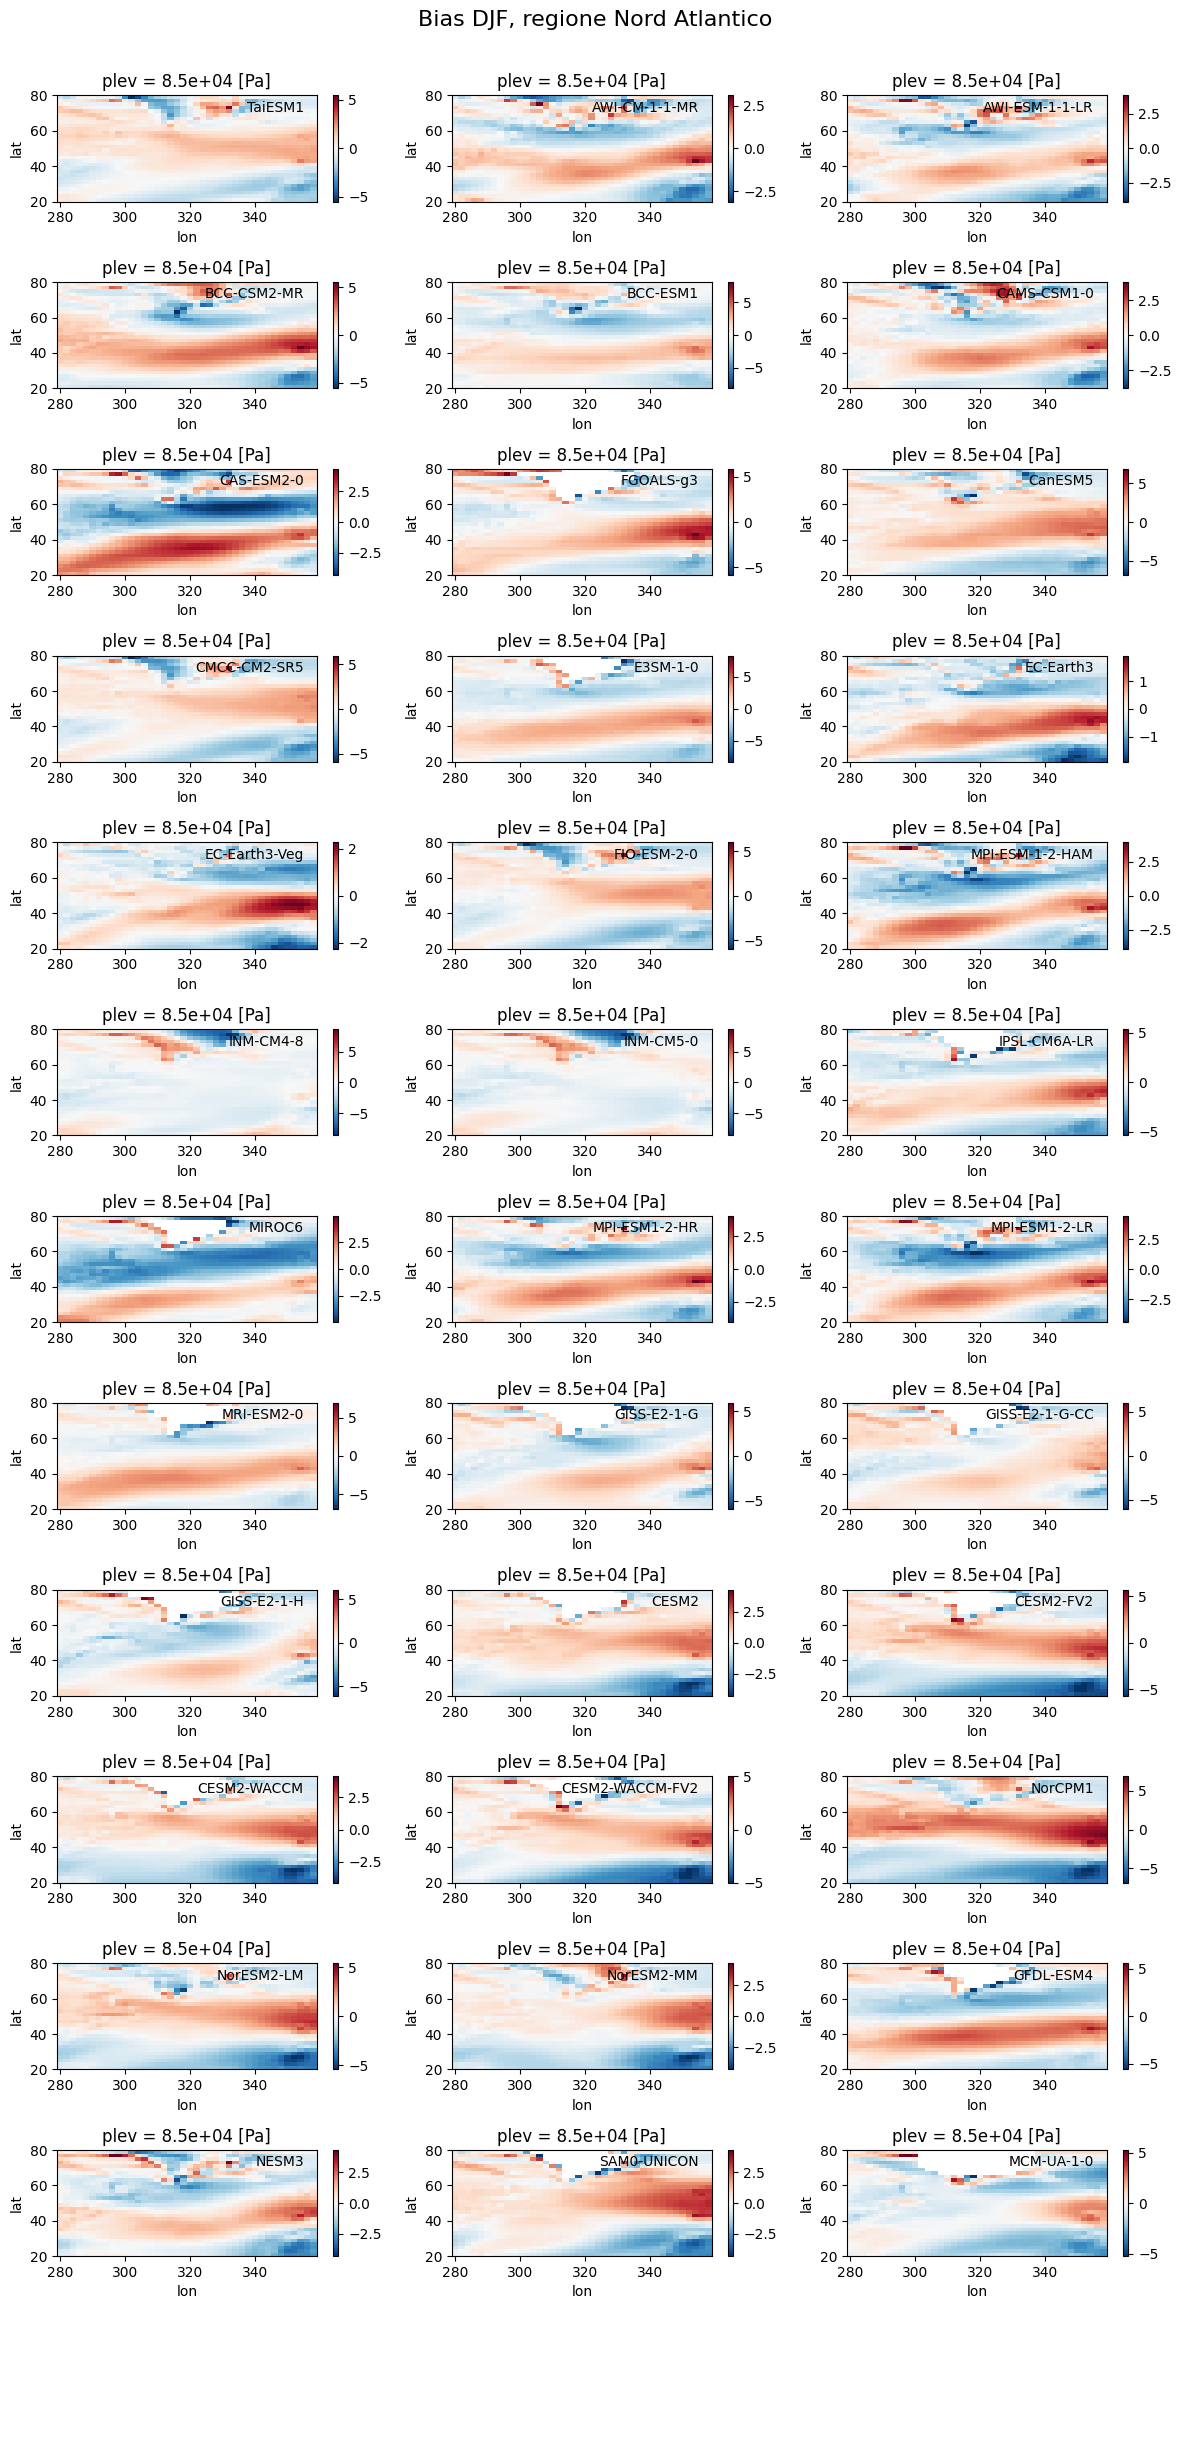

In [33]:
#Plot dei bias DJF dei modelli
fig, ax = plt.subplots(nrows=(int(len(models_atmos)/3)+1),ncols=3,figsize=(12,24))

for i in range((int(len(models_atmos)/3)+1)): #ciclo sulle righe
    for j in range(3): #ciclo sulle colonne
        models_index_list = i * 3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list_atmos_new):
            break
        model_name = models_list_atmos_new[models_index_list]
        data_array = models_atmos[model_name]['atmos North Atlantic bias DJF']
        plot_mod = data_array[0].plot.pcolormesh(ax=ax[i, j]) #ricontrolla perché
        # Fisso la scala
        #plot_mod.set_clim(vmin=-6, vmax=6)
        ax[i,j].set_ylabel('lat')
        ax[i,j].set_xlabel('lon')
        # Aggiungi il nome del modello in alto a destra
        ax[i,j].text(0.95, 0.95, model_name, horizontalalignment='right', verticalalignment='top', transform=ax[i,j].transAxes, fontsize=10, color='black')

#Rimuovo i quadrati non utilizzati
for i in range((int(len(models_atmos)/3)+1)):
    for j in range(3):
        models_index_list = i * 3 + j
        if models_index_list >= len(models_list_atmos_new):
            ax[i, j].axis('off')

fig.tight_layout()
# Titolo
fig.suptitle('Bias DJF, regione Nord Atlantico', fontsize=16, y=1.02)

fig.savefig('atmos_bias_djf.pdf', format='pdf')

In [19]:
print(models_list_atmos_new)

['TaiESM1', 'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'FGOALS-g3', 'CanESM5', 'CMCC-CM2-SR5', 'E3SM-1-0', 'EC-Earth3', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'MPI-ESM-1-2-HAM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorCPM1', 'NorESM2-LM', 'NorESM2-MM', 'GFDL-ESM4', 'NESM3', 'SAM0-UNICON', 'MCM-UA-1-0']


In [20]:
#Creo 5 liste, pari al numero di cluster, in cui racchiudo il nome dei modelli
list_cluster0 = ['TaiESM1', 'CMCC-CM2-SR5', 'ACCESS-ESM1-5', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'MCM-UA-1-0']
list_cluster1 = ['BCC-CSM2-MR', 'BCC-ESM1', 'FGOALS-g3', 'ACCESS-CM2', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H'] #NorCMP1
list_cluster2 = ['AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'CAS-ESM2-0', 'EC-Earth3', 'MPI-ESM-1-2-HAM', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GFDL-ESM4',  'NorCPM1'] #NorCMP1
list_cluster3 = ['INM-CM4-8', 'INM-CM5-0']
list_cluster4 = ['CAMS-CSM1-0', 'CanESM5', 'E3SM-1-0', 'NESM3']

In [21]:
#Tolgo dalle liste list_cluster0,...,4 gli elementi num_models
#inizializzazione indici liste 0,...,4
j = 0 
#inizializzo le nuove liste 0,...,4 perché non ci sono un # di modelli pari a num_models che non devono essere considerati
list_cluster0_new = []
list_cluster1_new = []
list_cluster2_new = []
list_cluster3_new = []
list_cluster4_new = []
#list_cluster0_new
for j in range(len(list_cluster0)):
    if list_cluster0[j] in models_list_atmos_new: 
        list_cluster0_new.append(list_cluster0[j])
        j = j + 1
#list_cluster1_new
j = 0
for j in range(len(list_cluster1)):
    if list_cluster1[j] in models_list_atmos_new: 
        list_cluster1_new.append(list_cluster1[j])
        j = j + 1
#list_cluster2_new
j = 0
for j in range(len(list_cluster2)):
    if list_cluster2[j] in models_list_atmos_new: 
        list_cluster2_new.append(list_cluster2[j])
        j = j + 1
#list_cluster3_new
j = 0
for j in range(len(list_cluster3)):
    if list_cluster3[j] in models_list_atmos_new: 
        list_cluster3_new.append(list_cluster3[j])
        j = j + 1
#list_cluster3_new
j = 0
for j in range(len(list_cluster4)):
    if list_cluster4[j] in models_list_atmos_new: 
        list_cluster4_new.append(list_cluster4[j])
        j = j + 1

Plot dei modelli nei 5 cluster di tos

Cluster 0

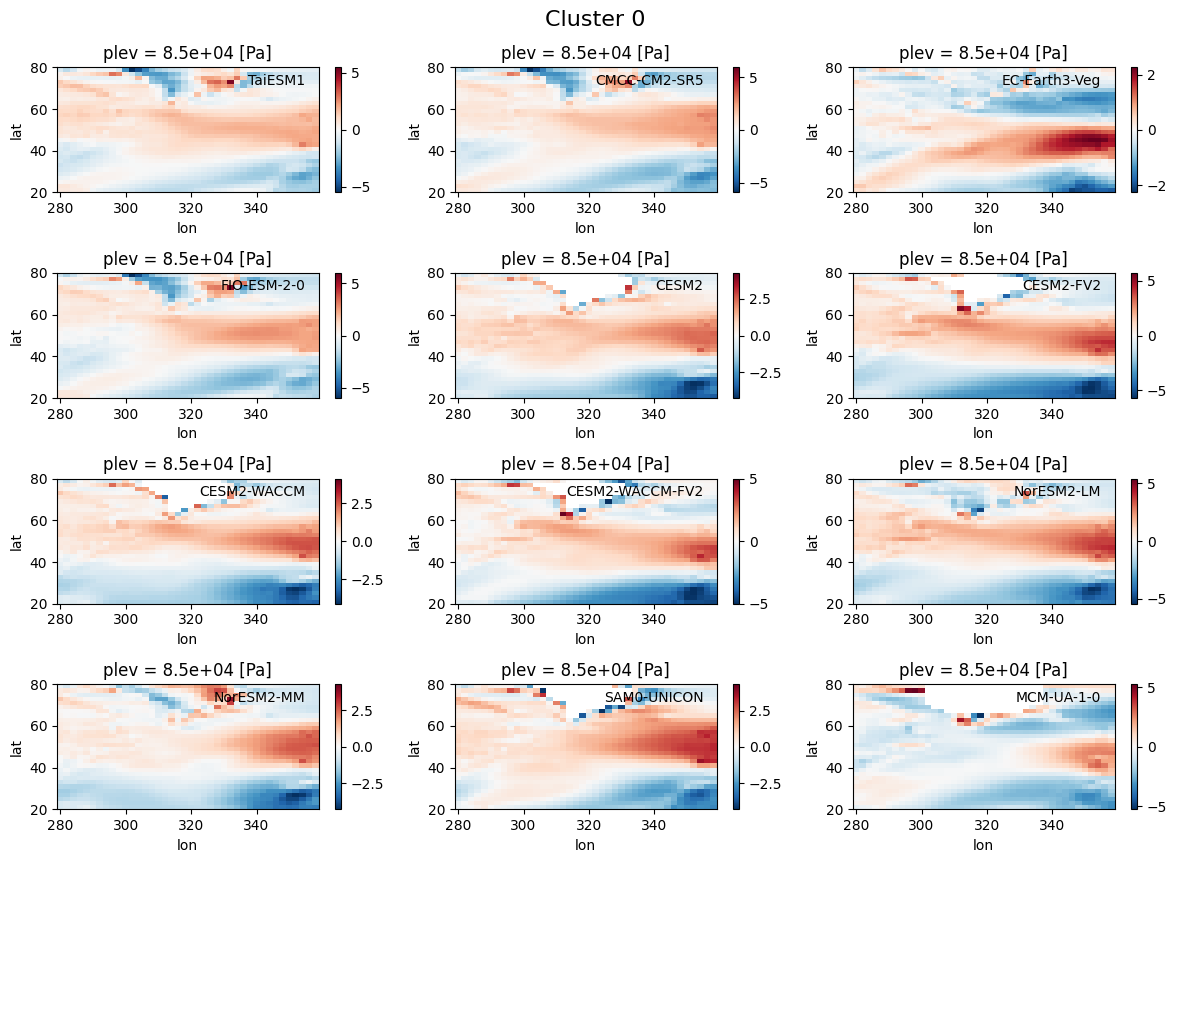

In [22]:
#cluster 0 ['TaiESM1', 'CMCC-CM2-SR5', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'MCM-UA-1-0']
#Plot dei bias DJF dei modelli
fig, ax = plt.subplots(nrows=(int(len(list_cluster0_new)/3)+1),ncols=3,figsize=(12,10))

for i in range((int(len(list_cluster0_new)/3)+1)): #ciclo sulle righe
    for j in range(3): #ciclo sulle colonne
        models_index_list = i * 3 + j #indice del modello all'interno della lista
        if models_index_list == len(list_cluster0_new):
            break
        model_name = list_cluster0_new[models_index_list]
        data_array = models_atmos[model_name]['atmos North Atlantic bias DJF']
        plot_mod = data_array[0].plot.pcolormesh(ax=ax[i, j]) #ricontrolla perché
        # Fisso la scala
        #plot_mod.set_clim(vmin=-6, vmax=6)
        ax[i,j].set_ylabel('lat')
        ax[i,j].set_xlabel('lon')
        
        # Aggiungi il nome del modello in alto a destra
        ax[i,j].text(0.95, 0.95, model_name, horizontalalignment='right', verticalalignment='top', transform=ax[i,j].transAxes, fontsize=10, color='black')

#Rimuovo i quadrati non utilizzati
for i in range((int(len(list_cluster0_new)/3)+1)):
    for j in range(3):
        models_index_list = i * 3 + j
        if models_index_list >= len(list_cluster0_new):
            ax[i, j].axis('off')

fig.tight_layout()
# Titolo
fig.suptitle('Cluster 0', fontsize=16, y=1.02)

fig.savefig('atmos_cluster0.pdf', format='pdf')

Cluster 0 medio

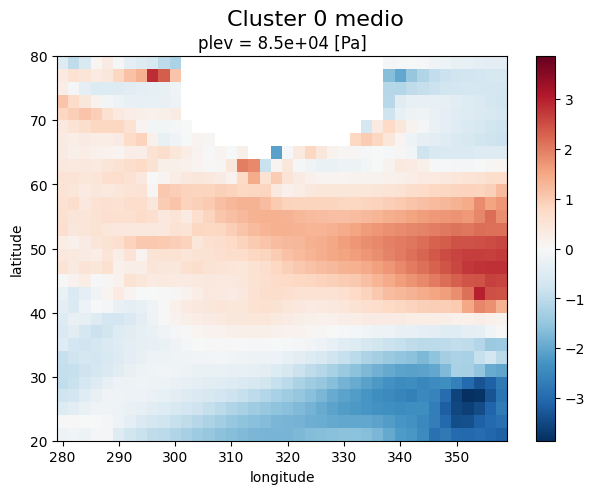

In [23]:
#cluster 0 medio 
#Inizializzo sum_bias per il calcolo della media
sum_bias = 0
#calcolo il valor medio
for i in range(len(list_cluster0_new)):
    model_name = list_cluster0_new[i]
    sum_bias = sum_bias + models_atmos[model_name]['atmos North Atlantic bias DJF']
#valor medio
mean_bias = sum_bias / len(list_cluster0_new)
#plot del valor medio per il cluster 3
plot_mod = mean_bias[0].plot.pcolormesh()
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.tight_layout()

# Titolo
plt.suptitle('Cluster 0 medio', fontsize=16, y=1.02)
plt.savefig('atmos_cluster0_mean.pdf', format='pdf')

Cluster 1

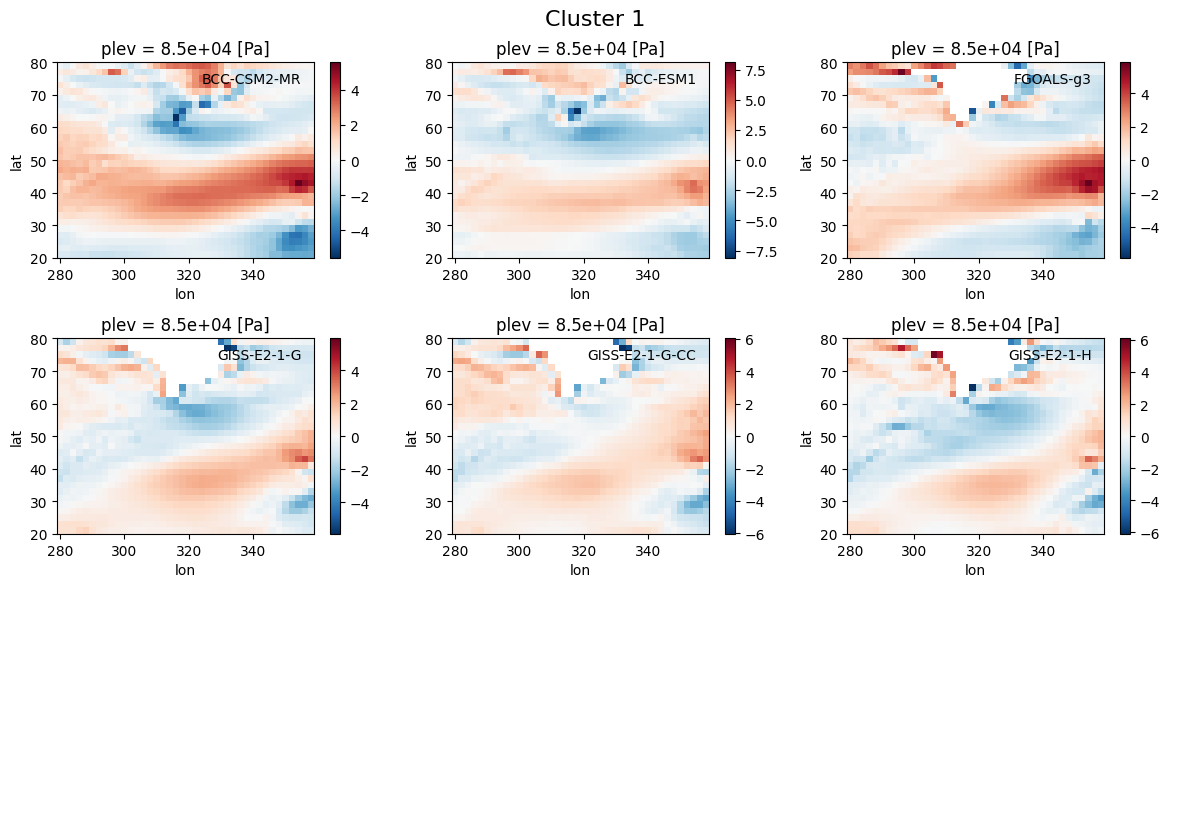

In [24]:
#cluster 1 ['BCC-CSM2-MR', 'BCC-ESM1', 'FGOALS-g3', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'NorCPM1']
#Plot dei bias DJF dei modelli
fig, ax = plt.subplots(nrows=(int(len(list_cluster1_new)/3)+1),ncols=3,figsize=(12,8))

for i in range((int(len(list_cluster1_new)/3)+1)): #ciclo sulle righe
    for j in range(3): #ciclo sulle colonne
        models_index_list = i * 3 + j #indice del modello all'interno della lista
        if models_index_list == len(list_cluster1_new):
            break
        model_name = list_cluster1_new[models_index_list]
        data_array = models_atmos[model_name]['atmos North Atlantic bias DJF']
        plot_mod = data_array[0].plot.pcolormesh(ax=ax[i, j]) #ricontrolla perché
        # Fisso la scala
        #plot_mod.set_clim(vmin=-6, vmax=6)
        ax[i,j].set_ylabel('lat')
        ax[i,j].set_xlabel('lon')
        
        # Aggiungi il nome del modello in alto a destra
        ax[i,j].text(0.95, 0.95, model_name, horizontalalignment='right', verticalalignment='top', transform=ax[i,j].transAxes, fontsize=10, color='black')

#Rimuovo i quadrati non utilizzati
for i in range((int(len(list_cluster1_new)/3)+1)):
    for j in range(3):
        models_index_list = i * 3 + j
        if models_index_list >= len(list_cluster1_new):
            ax[i, j].axis('off')

fig.tight_layout()
# Titolo
fig.suptitle('Cluster 1', fontsize=16, y=1.02)

fig.savefig('atmos_cluster1.pdf', format='pdf')

Cluster 1 medio

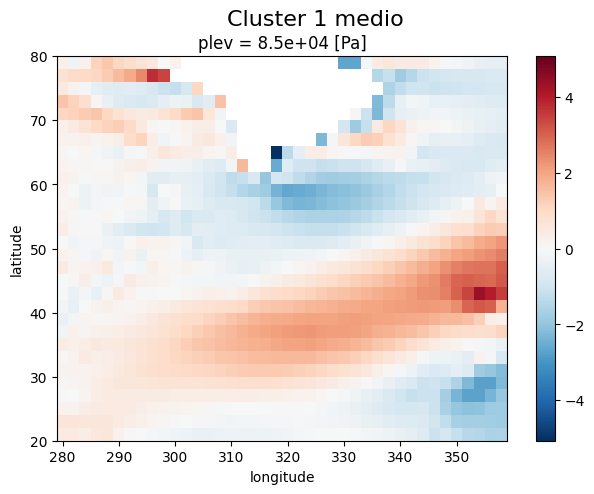

In [25]:
#cluster 1 medio 
#Inizializzo sum_bias per il calcolo della media
sum_bias = 0
#calcolo il valor medio
for i in range(len(list_cluster1_new)):
    model_name = list_cluster1_new[i]
    sum_bias = sum_bias + models_atmos[model_name]['atmos North Atlantic bias DJF']
#valor medio
mean_bias = sum_bias / len(list_cluster1_new)
#plot del valor medio per il cluster 3
plot_mod = mean_bias[0].plot.pcolormesh()
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.tight_layout()

# Titolo
plt.suptitle('Cluster 1 medio', fontsize=16, y=1.02)
plt.savefig('atmos_cluster1_mean.pdf', format='pdf')

Cluster 2

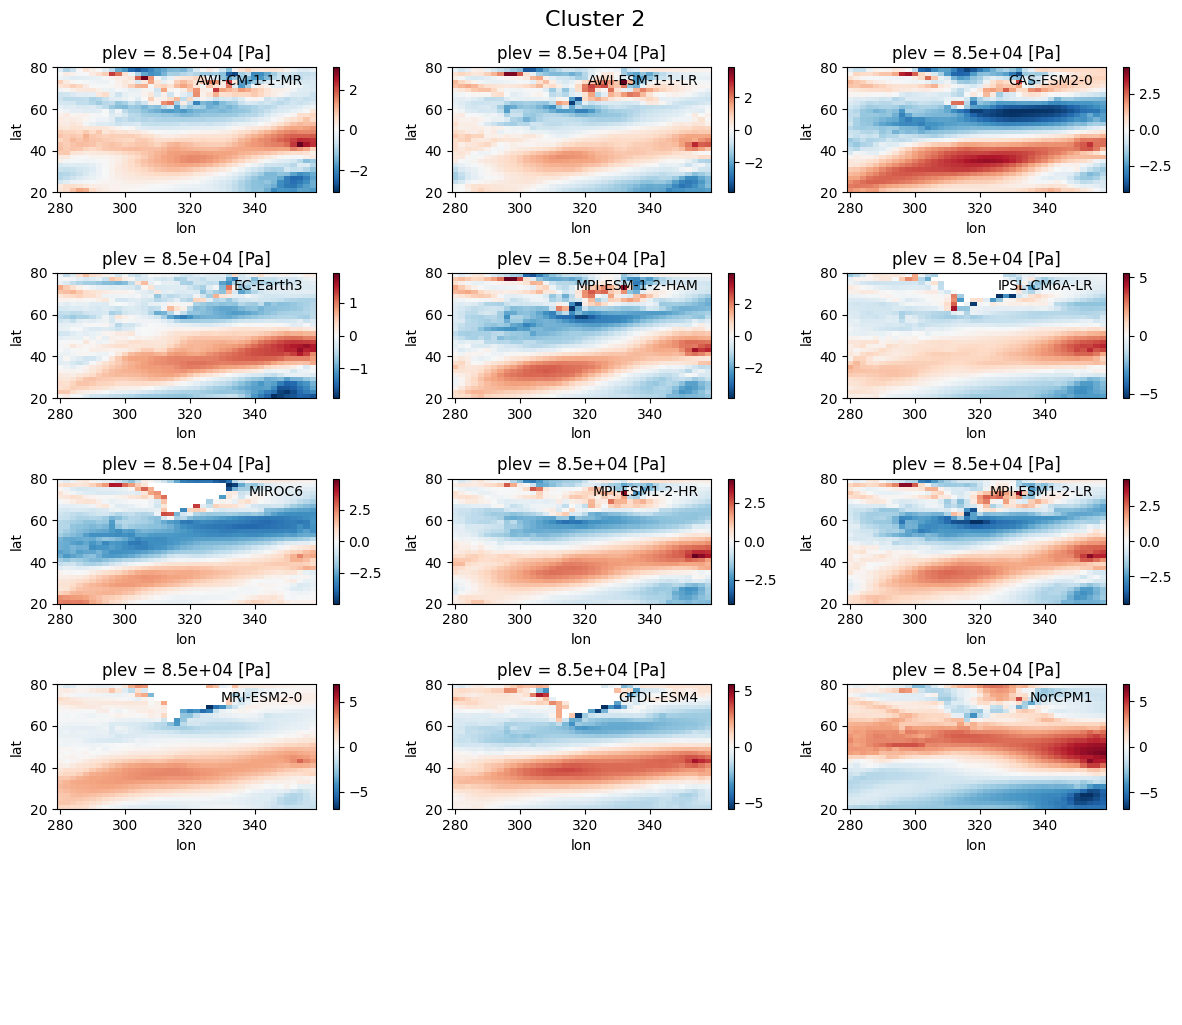

In [26]:
# Plot dei bias DJF dei modelli
fig, ax = plt.subplots(nrows=(int(len(list_cluster2_new)/3)+1), ncols=3, figsize=(12,10))

for i in range((int(len(list_cluster2_new)/3)+1)):# Ciclo sulle righe
    for j in range(3): # Ciclo sulle colonne
        models_index_list = i * 3 + j # Indice del modello all'interno della lista
        if models_index_list == len(list_cluster2_new):
            break
        model_name = list_cluster2_new[models_index_list]
        data_array = models_atmos[model_name]['atmos North Atlantic bias DJF']
        plot_mod = data_array[0].plot.pcolormesh(ax=ax[i, j]) # Plot
        # Fisso la scala
        #plot_mod.set_clim(vmin=-6, vmax=6)
        ax[i,j].set_ylabel('lat')
        ax[i,j].set_xlabel('lon')
        
        # Aggiungi il nome del modello in alto a destra
        ax[i,j].text(0.95, 0.95, model_name, horizontalalignment='right', verticalalignment='top', transform=ax[i,j].transAxes, fontsize=10, color='black')

# Rimuovo i quadrati non utilizzati
for i in range((int(len(list_cluster2_new)/3)+1)):
    for j in range(3):
        models_index_list = i * 3 + j
        if models_index_list >= len(list_cluster2_new):
            ax[i, j].axis('off')

fig.tight_layout()
# Titolo
fig.suptitle('Cluster 2', fontsize=16, y=1.02)

# Salvataggio del plot
fig.savefig('atmos_cluster2.pdf', format='pdf')



Cluster 2 medio

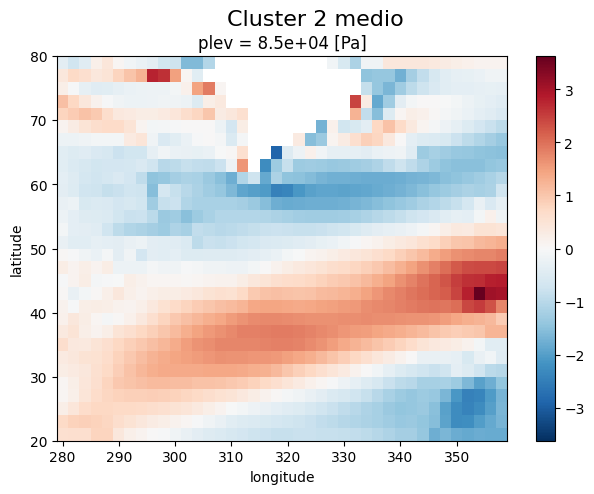

In [27]:
#cluster 2 medio 
#Inizializzo sum_bias per il calcolo della media
sum_bias = 0
#calcolo il valor medio
for i in range(len(list_cluster2_new)):
    model_name = list_cluster2_new[i]
    sum_bias = sum_bias + models_atmos[model_name]['atmos North Atlantic bias DJF']
#valor medio
mean_bias = sum_bias / len(list_cluster2_new)
#plot del valor medio per il cluster 3
plot_mod = mean_bias[0].plot.pcolormesh()
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.tight_layout()

# Titolo
plt.suptitle('Cluster 2 medio', fontsize=16, y=1.02)
plt.savefig('atmos_cluster2_mean.pdf', format='pdf')

Cluster 3

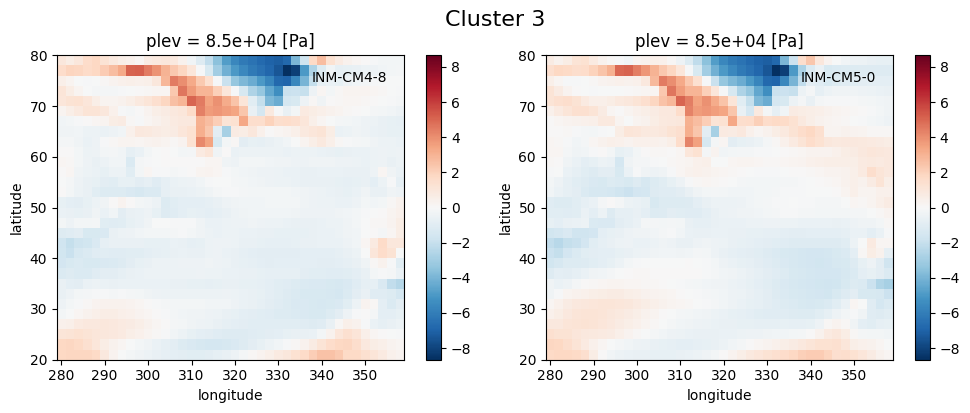

In [32]:
#Plot del cluster 3 pca (2 elementi 19-20) ['INM-CM4-8', 'INM-CM5-0']
#Plot dei modelli
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))  # Modificato per 2 righe e 1 colonna

# Plot dei modelli
for i in range(2):  # Solo 2 righe
    model_name = list_cluster3_new[i]  # Usa l'indice i direttamente
    data_array = models_atmos[model_name]['atmos North Atlantic bias DJF']
    plot_mod = data_array[0].plot.pcolormesh(ax=ax[i])
    ax[i].set_ylabel('latitude')
    ax[i].set_xlabel('longitude')        
    # Aggiungi il nome del modello in alto a destra
    ax[i].text(0.95, 0.95, model_name, horizontalalignment='right', verticalalignment='top', transform=ax[i].transAxes, fontsize=10, color='black')


# Rimuovi i quadrati non utilizzati
for i in range(2):
    if i >= len(list_cluster3_new):  # Modificato per usare solo l'indice i
        ax[i].axis('off')

fig.tight_layout()
fig.suptitle('Cluster 3', fontsize=16, y=1.02)
fig.savefig('atmos_cluster_3.pdf', format='pdf')

Cluster 3 medio

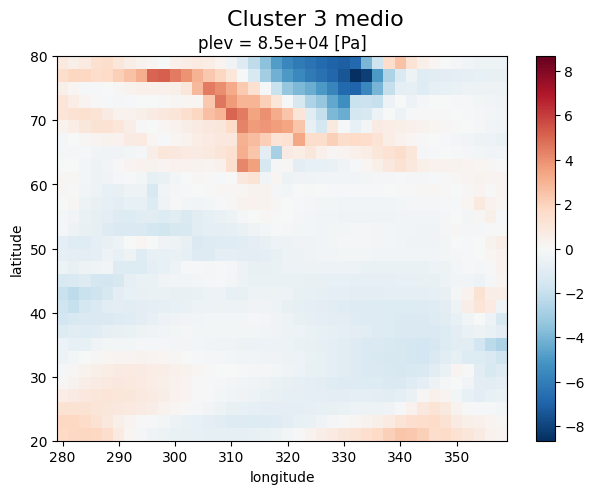

In [29]:
#cluster 3 medio 
#Inizializzo sum_bias per il calcolo della media
sum_bias = 0
#calcolo il valor medio
for i in range(len(list_cluster3_new)):
    model_name = list_cluster3_new[i]
    sum_bias = sum_bias + models_atmos[model_name]['atmos North Atlantic bias DJF']
#valor medio
mean_bias = sum_bias / len(list_cluster3_new)
#plot del valor medio per il cluster 3
plot_mod = mean_bias[0].plot.pcolormesh()
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.tight_layout()

# Titolo
plt.suptitle('Cluster 3 medio', fontsize=16, y=1.02)
plt.savefig('atmos_cluster3_mean.pdf', format='pdf')

Cluster 4

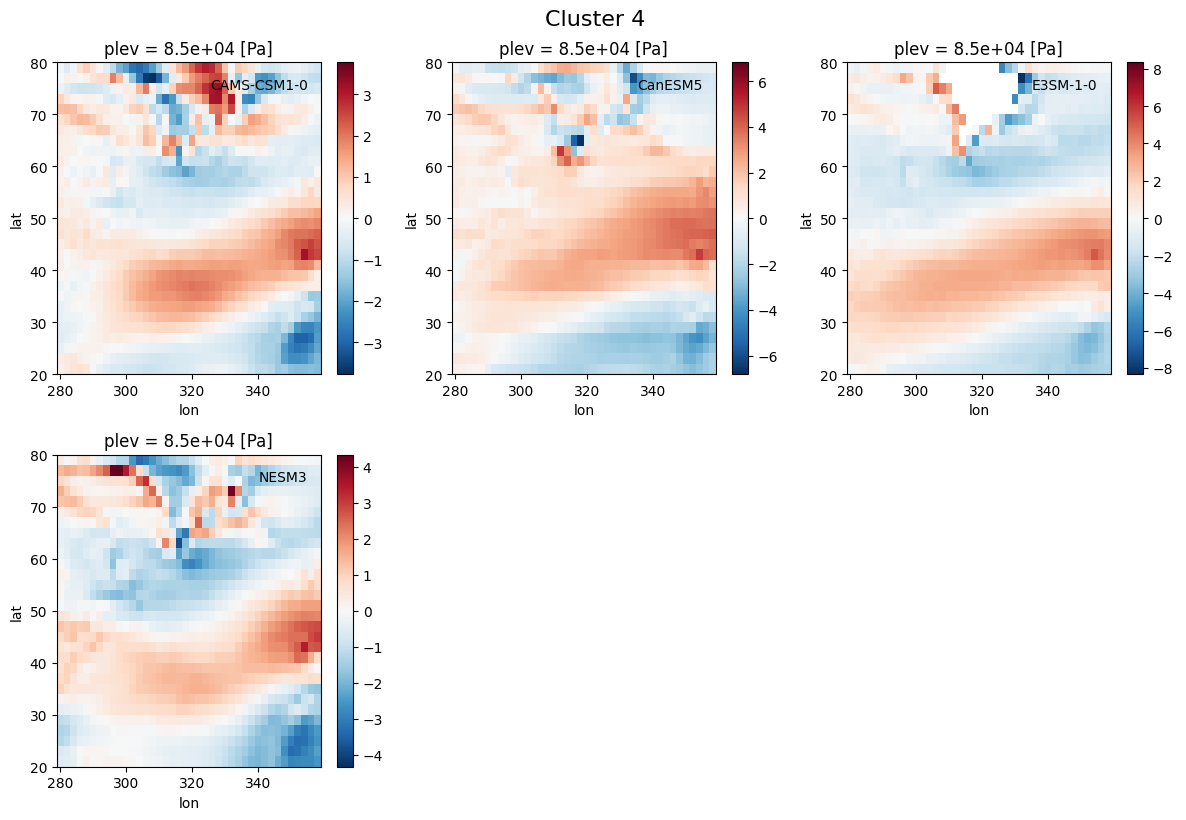

In [30]:
#cluster 4 ['CAMS-CSM1-0', 'CanESM5', 'E3SM-1-0', 'NESM3']
#Plot dei bias DJF dei modelli
fig, ax = plt.subplots(nrows=(int(len(list_cluster4_new)/3)+1),ncols=3,figsize=(12,8))

for i in range((int(len(list_cluster4_new)/3)+1)): #ciclo sulle righe
    for j in range(3): #ciclo sulle colonne
        models_index_list = i * 3 + j #indice del modello all'interno della lista
        if models_index_list == len(list_cluster4_new):
            break
        model_name = list_cluster4_new[models_index_list]
        data_array = models_atmos[model_name]['atmos North Atlantic bias DJF']
        plot_mod = data_array[0].plot.pcolormesh(ax=ax[i, j]) #ricontrolla perché
        # Fisso la scala
        #plot_mod.set_clim(vmin=-6, vmax=6)
        ax[i,j].set_ylabel('lat')
        ax[i,j].set_xlabel('lon')
        
        # Aggiungi il nome del modello in alto a destra
        ax[i,j].text(0.95, 0.95, model_name, horizontalalignment='right', verticalalignment='top', transform=ax[i,j].transAxes, fontsize=10, color='black')

#Rimuovo i quadrati non utilizzati
for i in range((int(len(list_cluster4_new)/3)+1)):
    for j in range(3):
        models_index_list = i * 3 + j
        if models_index_list >= len(list_cluster4_new):
            ax[i, j].axis('off')

fig.tight_layout()
# Titolo
fig.suptitle('Cluster 4', fontsize=16, y=1.02)

fig.savefig('atmos_cluster4.pdf', format='pdf')

Cluster 4 medio

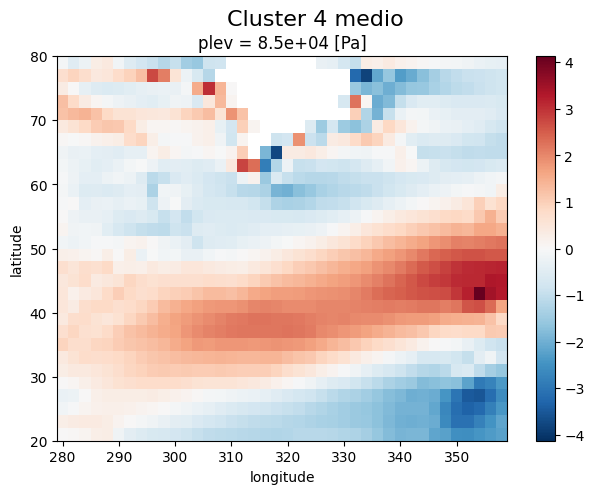

In [34]:
#cluster 4 medio 
#Inizializzo sum_bias per il calcolo della media
sum_bias = 0
#calcolo il valor medio
for i in range(len(list_cluster4_new)):
    model_name = list_cluster4_new[i]
    sum_bias = sum_bias + models_atmos[model_name]['atmos North Atlantic bias DJF']
#valor medio
mean_bias = sum_bias / len(list_cluster4_new)
#plot del valor medio per il cluster 3
plot_mod = mean_bias[0].plot.pcolormesh()
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.tight_layout()

# Titolo
plt.suptitle('Cluster 4 medio', fontsize=16, y=1.02)
plt.savefig('atmos_cluster4_mean.pdf', format='pdf')